# Import libraries

We are going to use TPUs for this, since transformers including distilBERT are very heavy duty, and we'll need a lot of computational power for this one.

In [1]:
pip install html_text bs4 requests transformers

     |████████████████████████████████| 2.1MB 5.4MB/s 
     |████████████████████████████████| 3.3MB 23.5MB/s 
     |████████████████████████████████| 901kB 42.4MB/s 


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

from transformers import DistilBertTokenizer, DistilBertConfig, TFDistilBertModel
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, LSTM, MaxPooling1D, Dense, Dropout, GlobalMaxPooling1D, Input, Bidirectional, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Initializing the TPU system: grpc://10.78.163.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.78.163.242:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


# Load data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/welc.csv")
data.sample(5)

,data,class
76,never,no
90,hey there,hi
45,no no don't,no
63,no we are good,no
33,alright why not,yes


In [5]:
data = data.dropna().reset_index(drop=True)

In [6]:
data["class"] = data["class"].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   data    103 non-null    object  
 1   class   103 non-null    category
dtypes: category(1), object(1)
memory usage: 1.1+ KB


In [7]:
cat = list(set(data['class'].unique()))

In [8]:
category = {cat[i]:i for i in range(len(cat))}
data["class"] = data["class"].replace(category)
data.sample(3)

,data,class
44,no,0
22,yes I agree,1
66,not right now,0


In [9]:
category

{'hi': 2, 'no': 0, 'yes': 1}

In [10]:
text = np.array([str(t) for t in data['data'].values])
labels = data['class'].values

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff3f94ac810>]],
      dtype=object)

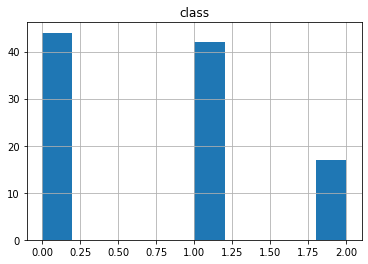

In [11]:
data.hist(column="class")

In [12]:
X_train, x_test, y_train, y_test = train_test_split(text, labels, random_state=1, test_size=0.15)
maxlen = 10

# Define tokenizer

In [13]:
vocab_size = 500
embed_size = 64
distil_bert = 'distilbert-base-uncased'

tokenizer = DistilBertTokenizer.from_pretrained(distil_bert, do_lower_case=True, add_special_tokens=True, max_length=maxlen, pad_to_max_length=True)

def tokenize(sentences, tokenizer):
    input_ids, input_masks = [], []
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=maxlen, pad_to_max_length=True, return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32')

# Tokenize data using defined tokenizer

In [14]:
# Tokenize desc and title train data
X_train = tokenize(X_train, tokenizer)
x_test = tokenize(x_test, tokenizer)

  0%|          | 0/87 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 16/16 [00:00<00:00, 3228.72it/s]


# Define model in TPU scope

In [22]:
with tpu_strategy.scope():
    config = DistilBertConfig(dropout=0.4, attention_dropout=0.4)
    config.output_hidden_states = False
    transformer_model = TFDistilBertModel.from_pretrained(distil_bert, config=config)
    input_ids_in = tf.keras.layers.Input(shape=(maxlen,), name='input_token', dtype='int32')
    input_masks_in = tf.keras.layers.Input(shape=(maxlen,), name='masked_token', dtype='int32')
    embedding_layer = transformer_model.distilbert([input_ids_in, input_masks_in])[0]
    X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(embedding_layer)
    X = tf.keras.layers.GlobalMaxPool1D()(X)
    X = tf.keras.layers.Dropout(0.4)(X)
    X = tf.keras.layers.Dense(10, activation='softmax')(X)
    model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

    for layer in model.layers[:3]:
        layer.trainable = False

    model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'activation_13', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 50)]         0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 50)]         0                                            
__________________________________________________________________________________________________
distilbert (TFDistilBertMainLay TFBaseModelOutput(la 66362880    input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 50, 128)      426496      distilbert[0][0]           

# Compile and fit model

In [23]:
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        min_delta=1e-4,
        patience=3,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='weights.h5',
        monitor='val_accuracy', 
        mode='max', 
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

In [24]:
from tensorflow.keras.optimizers import Adam
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=128, validation_data=(x_test, y_test), epochs=10, callbacks=callbacks)

Epoch 1/50
1/1 [==============================] - 24s 24s/step - loss: 2.8717 - accuracy: 0.0115 - val_loss: 2.2167 - val_accuracy: 0.0625

Epoch 00001: val_accuracy improved from -inf to 0.06250, saving model to weights.h5
Epoch 2/50
1/1 [==============================] - 1s 615ms/step - loss: 2.1870 - accuracy: 0.1724 - val_loss: 1.8806 - val_accuracy: 0.2500

Epoch 00002: val_accuracy improved from 0.06250 to 0.25000, saving model to weights.h5
Epoch 3/50
1/1 [==============================] - 1s 576ms/step - loss: 1.7767 - accuracy: 0.4943 - val_loss: 1.6428 - val_accuracy: 0.3125

Epoch 00003: val_accuracy improved from 0.25000 to 0.31250, saving model to weights.h5
Epoch 4/50
1/1 [==============================] - 1s 553ms/step - loss: 1.6002 - accuracy: 0.4368 - val_loss: 1.4810 - val_accuracy: 0.3125

Epoch 00004: val_accuracy did not improve from 0.31250
Epoch 5/50
1/1 [==============================] - 1s 612ms/step - loss: 1.3924 - accuracy: 0.5057 - val_loss: 1.3553 - val_a

In [25]:
model.load_weights('weights.h5')

# Test model with some arbitrary data

In [28]:
test = ["no"]
print(test)
labels = {v: k for k, v in category.items()}
# print (test)
test_seq = tokenize(test, tokenizer)
test_preds = [labels[np.argmax(i)] for i in model.predict(test_seq)]
# print(model.predict(test_seq))
print(test_preds)

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 1/1 [00:00<00:00, 843.58it/s]

['no']


['no']


In [29]:
labels

{0: 'no', 1: 'yes', 2: 'hi'}